
# Qiskit


Qiskit is an open-source software development kit (SDK) for quantum computation. It runs inside Python platform.

QIskit provides a large set of tools for

1. developing new quantum algorithms and exploring new idea
2. constructing a quantum circuit and testing it by running simulation on a classical computer
3. executing the circuit on a real quantum computer through IBM Quantum Experience.

We will use QIskit for all these three important coding steps.

You can find useful information about Qiskit including tutorials and API documentation at [qiskit.org](https://qiskit.org).

## Installation

It is a set of python libraries but not included in Anaconda.  We need to install them manually.

```
pip install qiskit
pip install qiskit[visualization]
```

Since conda does not manage these packages, you must update the package when a new version becomes available.  To check the current version, run the following command in the anaconda terminal window.

On MS Windows, use Anaconda Powershell Prompt.
```
pip list | select-string "qiskit"

qiskit                            0.36.2
qiskit-aer                        0.10.4
qiskit-ibmq-provider              0.19.1
qiskit-ignis                      0.7.1
qiskit-terra                      0.20.2
```

On Linux
```
pip list | grep qiskit

qiskit                            0.36.2
qiskit-aer                        0.10.4
qiskit-ibmq-provider              0.19.1
qiskit-ignis                      0.7.1
qiskit-terra                      0.20.2
```

To check if updates are available, the following command shows newer versions.

```
# On MS Windows
pip list --outdated | select-string "qiskit"

# On Linux
pip list --outdated | grep qiskit
```



## IBM Quantum Experience

In order to take the full advantage of Qiskit, you must first create an IBM Quantum Experience account.  With IBMid, you can run Qiskit codes on real IBM quantum computers as well as on realistic simulations on your computer.  Go to
[quantum-computing.ibm.com](https://quantum-computing.ibm.com/) and set up an account.
Log in to your account and take a look at IBM Quantum Dashboard where you find many useful stuffs which we discuss in later chapters.


## API key

Next, you need to obtain an API key and save it in a local computer.

1. Log in to IBM Quantum Experience at [quantum-computing.ibm.com](https://quantum-computing.ibm.com/)
2. Click the user icon at the upper-right corner.
3. Click "Account setting".
4. Click "Generate new token"
5. Click copy icon at the right end of the token box.  Your token is copied to the clipboard.
6. Open a text editor and paste the token.  Save it it to a temporary file so that you can copy the token at a later time if needed. Delete the file after the key is properly installed.
7. Open an Anaconda terminal window.
8. Start python and execute the following command at the python prompt:

```
>>> from qiskit import IBMQ
>>> IBMQ.save_account('past your token here')
```
The token must be inside the single quotes.  Now, we verify if the token works.

```
>>> IBMQ.load_account()
```
You should get the following response:
```
<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>
```
If it worked, delete the temporary file created at step 6.  Otherwise, something went wrong. Try step 8 again.  Make it sure that the whole key is pasted.

If you work on multiple computers, you have to install the same API on each machine.

## Using Qiskit

Since Qiskit is a collection of python modules, we must import it to your code before using it.  The package is so large that importing the entire package is not a good idea. In this book, we use only a small portion of it.  As you move on, this book introduces some basic modules absolutely necessary for quantum computing and explains how to use them step by step.

## Suggested Reading

As mentioned above, there are various online resources at [qiskit.org](https://qiskit.org) and [quantum-computing.ibm.com](https://quantum-computing.ibm.com/). In particular, the following online textbook is recommended.

* [Learn Quantum Computation using Qiskit](https://qiskit.org/textbook/)

In addition, the following paperback book is recommended.

* H. Norl&eacute;n: [*Quantum Computing in Practice with Qiskit and IBM Quantum Experience*](https://www.packtpub.com/product/quantum-computing-in-practice-with-qiskit-and-ibm-quantum-experience/9781838828448) (Packt, 2020).
Source codes can be obtained at [github](https://github.com/PacktPublishing/Quantum-Computing-in-Practice-with-Qiskit-and-IBM-Quantum-Experience).

In [12]:
# Appendix A: Full Qiskit Implementation
# Filename suggestion: quantum_game_theory_appendix.py
#
# Dependencies:
#   qiskit, numpy, matplotlib
#   pip install qiskit numpy matplotlib
#
# Note on bitstrings: Qiskit counts return bitstrings with qubit (n-1 ... 0).
# For a 2-qubit circuit with measure_all(), counts keys like '10' mean:
#   left char -> qubit 1, right char -> qubit 0
# To extract qubit-0 bit: outcome[-1]; qubit-1 bit: outcome[-2].

import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit_aer import Aer
from qiskit_aer.noise import NoiseModel, depolarizing_error, amplitude_damping_error
from qiskit.quantum_info import Statevector

# -----------------------------
# Utility: Entangler and Strategy
# -----------------------------
def entangler(circ: QuantumCircuit, gamma: float, q0: int = 0, q1: int = 1):
    """
    Implements J(gamma) entangler using CX-RX-CX pattern.
    Note: equivalent forms exist (RXX gate, etc.). This is simple & explicit.
    """
    circ.cx(q0, q1)
    circ.rx(2 * gamma, q1)
    circ.cx(q0, q1)

def strategy_gate(circ: QuantumCircuit, theta: float, phi: float, qubit: int):
    """
    Implements a two-parameter strategy U(theta, phi).
    Equivalent to rotation + phase: R_y(theta) then R_z(phi).
    """
    circ.ry(theta, qubit)
    circ.rz(phi, qubit)

# -----------------------------
# Payoff definitions: Prisoner's Dilemma
# -----------------------------
# Standard PD payoff (R=3, T=5, S=0, P=1)
# Map measurement outcomes 'q1 q0': q0 = player's 0 choice, q1 = player's 1 choice
# Convention: '0' -> Cooperate (C), '1' -> Defect (D)
PD_PAYOFF = {
    '00': (3, 3),  # (C,C)
    '01': (0, 5),  # (C,D) -> qubit1=0 qubit0=1 means player0 defects, player1 cooperates? careful with ordering
    '10': (5, 0),
    '11': (1, 1),
}
# NOTE: adjust mapping if your measurement ordering is different.

def compute_payoff_from_counts(counts: dict, payoff_map: dict):
    """
    Given counts dict from Qiskit (e.g. {'00':512, '11':512}), compute expected payoffs.
    Assumes keys are strings with qubit (n-1 ... 0) ordering, so:
      - for two qubits: outcome[-1] is qubit0, outcome[-2] is qubit1
    """
    total = sum(counts.values())
    pa = 0.0
    pb = 0.0
    for bitstr, c in counts.items():
        # Use bitstr as-is because payoff_map keys use same ordering
        if bitstr not in payoff_map:
            # If bitstring length mismatches (e.g., spaces), standardize:
            bitstr = bitstr.replace(' ', '')
        payoff_a, payoff_b = payoff_map[bitstr]
        prob = c / total
        pa += payoff_a * prob
        pb += payoff_b * prob
    return pa, pb

# -----------------------------
# Build and run Prisoner's Dilemma circuit
# -----------------------------
def run_quantum_pd(theta_A, phi_A, theta_B, phi_B, gamma,
                   shots=2000, backend_name='aer_simulator', noise_model=None):
    """
    Builds the PD circuit with EWL quantization and returns counts and expected payoffs.
    """
    qc = QuantumCircuit(2, 2)
    # initialize |00> implicitly by default (no explicit init required)
    entangler(qc, gamma, 0, 1)
    # Apply player strategies: map player A -> qubit 0, player B -> qubit 1 (consistent)
    strategy_gate(qc, theta_A, phi_A, 0)
    strategy_gate(qc, theta_B, phi_B, 1)
    entangler(qc, -gamma, 0, 1)  # disentangle (J^dagger)
    qc.measure(0, 0)
    qc.measure(1, 1)

    backend = Aer.get_backend(backend_name)
    job = backend.run(qc, shots=shots, noise_model=noise_model)
    result = job.result()
    counts = result.get_counts(qc)
    payoff_A, payoff_B = compute_payoff_from_counts(counts, PD_PAYOFF)
    return counts, payoff_A, payoff_B

# -----------------------------
# Sweeps: strategy space and entanglement
# -----------------------------
def sweep_pd(theta_vals, phi_vals, gamma_vals, shots=2000, noise_model=None):
    """
    Sweeps over theta_A=theta_B in theta_vals and phi_A=phi_B in phi_vals for each gamma.
    Returns a dict: results[gamma] = 2D array of average payoff for symmetric strategies.
    """
    results = {}
    for gamma in gamma_vals:
        grid = np.zeros((len(theta_vals), len(phi_vals)))
        for i, theta in enumerate(theta_vals):
            for j, phi in enumerate(phi_vals):
                _, pa, pb = run_quantum_pd(theta, phi, theta, phi, gamma, shots=shots, noise_model=noise_model)
                grid[i, j] = (pa + pb) / 2  # symmetric average payoff
        results[gamma] = grid
    return results

# -----------------------------
# Noise models: depolarizing and amplitude damping
# -----------------------------
def make_depolarizing_noise_model(p: float):
    nm = NoiseModel()
    # Depolarizing for single- and two-qubit gates (approx)
    single_err = depolarizing_error(p, 1)
    two_err = depolarizing_error(p, 2)
    nm.add_all_qubit_quantum_error(single_err, ['ry', 'rz', 'rx'])
    nm.add_all_qubit_quantum_error(two_err, ['cx'])
    return nm

def make_amplitude_damping_noise_model(p: float):
    nm = NoiseModel()
    single_err = amplitude_damping_error(p)
    # Apply to single-qubit gates and also to CNOT as single-qubit after decomposition
    nm.add_all_qubit_quantum_error(single_err, ['ry', 'rz', 'rx', 'u1', 'u2', 'u3'])
    return nm

# -----------------------------
# Example: run and plot PD payoff vs gamma for (Q,Q) strategy
# -----------------------------
def example_pd_plot_gamma_vs_payoff():
    # Define "Q" strategy in EWL often corresponds to specific theta,phi; using theta = 0, phi = pi/2 is a common choice
    Q_theta, Q_phi = np.pi/2, np.pi/2  # tune as per your definition of Q
    gamma_vals = np.linspace(0, np.pi/2, 11)
    ideal_payoffs = []
    for gamma in gamma_vals:
        _, pa, pb = run_quantum_pd(Q_theta, Q_phi, Q_theta, Q_phi, gamma, shots=5000, noise_model=None)
        ideal_payoffs.append((pa + pb) / 2)
    plt.figure()
    plt.plot(gamma_vals, ideal_payoffs, marker='o')
    plt.xlabel('Entanglement gamma (rad)')
    plt.ylabel('Average payoff (Q,Q)')
    plt.title('PD: Average payoff (Q,Q) vs entanglement (ideal)')
    plt.grid(True)
    plt.savefig('pd_payoff_vs_gamma.png', dpi=200)
    plt.close()

# -----------------------------
# Minority Game (3 players) implementation
# -----------------------------
def build_ghz_state(circ: QuantumCircuit):
    circ.h(0)
    circ.cx(0, 1)
    circ.cx(0, 2)

def run_quantum_minority(theta_list, phi_list, gamma=None, shots=5000, noise_model=None):
    """
    theta_list, phi_list: lists of length 3 for players 0,1,2.
    Returns counts and expected payoffs (list of three floats).
    Payoff rule: a player gets 1 if they are in the minority (i.e., their bit differs from majority)
    """
    qc = QuantumCircuit(3, 3)
    # Prepare GHZ state (or default product state if you prefer)
    build_ghz_state(qc)
    # Optional entangling adjustment: gamma not explicitly used in GHZ here, but you can parameterize
    # Apply each player's strategy on their qubit
    for i in range(3):
        strategy_gate(qc, theta_list[i], phi_list[i], i)
    # Measure
    qc.measure(range(3), range(3))

    backend = Aer.get_backend('aer_simulator')
    job = backend.run(qc, shots=shots, noise_model=noise_model)
    counts = job.result().get_counts(qc)

    # Compute expected payoffs
    total = sum(counts.values())
    payoffs = np.zeros(3)
    for bitstr, c in counts.items():
        bstr = bitstr.replace(' ', '')
        # Interpret bits: bstr[-1] -> qubit0, bstr[-2] -> qubit1, bstr[-3] -> qubit2
        bits = [int(bstr[-1]), int(bstr[-2]), int(bstr[-3])]
        # Count ones: minority means exactly one or exactly two? For 3 players, minority size = 1 (or majority size = 2)
        # If exactly one player picks a different choice than the other two, that player is in minority.
        ones = sum(bits)
        if ones == 1:
            # the single '1' is minority
            idx = bits.index(1)
            payoffs[idx] += (c / total) * 1.0
        elif ones == 2:
            # the single '0' is minority
            idx = bits.index(0)
            payoffs[idx] += (c / total) * 1.0
        else:
            # all same => nobody gets payoff
            pass
    return counts, payoffs.tolist()

# -----------------------------
# Noise sweep example for PD (dep vs amp damp)
# -----------------------------
def sweep_noise_pd(p_vals, shots=5000, strategy='Q'):
    # Choose a representative strategy (Q)
    Q_theta, Q_phi = np.pi/2, np.pi/2
    dep_payoffs = []
    amp_payoffs = []
    for p in p_vals:
        dep_nm = make_depolarizing_noise_model(p)
        amp_nm = make_amplitude_damping_noise_model(p)
        _, dep_pa, dep_pb = run_quantum_pd(Q_theta, Q_phi, Q_theta, Q_phi, gamma=np.pi/4, shots=shots, noise_model=dep_nm)
        _, amp_pa, amp_pb = run_quantum_pd(Q_theta, Q_phi, Q_theta, Q_phi, gamma=np.pi/4, shots=shots, noise_model=amp_nm)
        dep_payoffs.append((dep_pa + dep_pb) / 2)
        amp_payoffs.append((amp_pa + amp_pb) / 2)
    # Plot
    plt.figure()
    plt.plot(p_vals, dep_payoffs, marker='o', label='Depolarizing')
    plt.plot(p_vals, amp_payoffs, marker='s', label='Amplitude Damping')
    plt.xlabel('Noise probability p')
    plt.ylabel('Average payoff (Q,Q)')
    plt.title('PD: Noise vs Average Payoff (gamma=pi/4)')
    plt.legend()
    plt.grid(True)
    plt.savefig('pd_noise_vs_payoff.png', dpi=200)
    plt.close()

# -----------------------------
# Example runner
# -----------------------------
if __name__ == "__main__":
    # small demos (set shots lower if running locally)
    print("Running example PD gamma sweep (this may take a bit)...")
    example_pd_plot_gamma_vs_payoff()
    print("Saved pd_payoff_vs_gamma.png")

    print("Running noise sweep (PD)....")
    p_vals = np.linspace(0, 0.3, 7)
    sweep_noise_pd(p_vals, shots=3000)
    print("Saved pd_noise_vs_payoff.png")

    print("Running a sample Minority Game (GHZ) example...")
    thetas = [np.pi/4, np.pi/4, np.pi/4]  # sample strategies
    phis = [0.0, 0.0, 0.0]
    counts, payoffs = run_quantum_minority(thetas, phis, shots=3000, noise_model=None)
    print("Minority game sample payoffs:", payoffs)


Running example PD gamma sweep (this may take a bit)...
Saved pd_payoff_vs_gamma.png
Running noise sweep (PD)....
Saved pd_noise_vs_payoff.png
Running a sample Minority Game (GHZ) example...
Minority game sample payoffs: [0.139, 0.12533333333333332, 0.13]


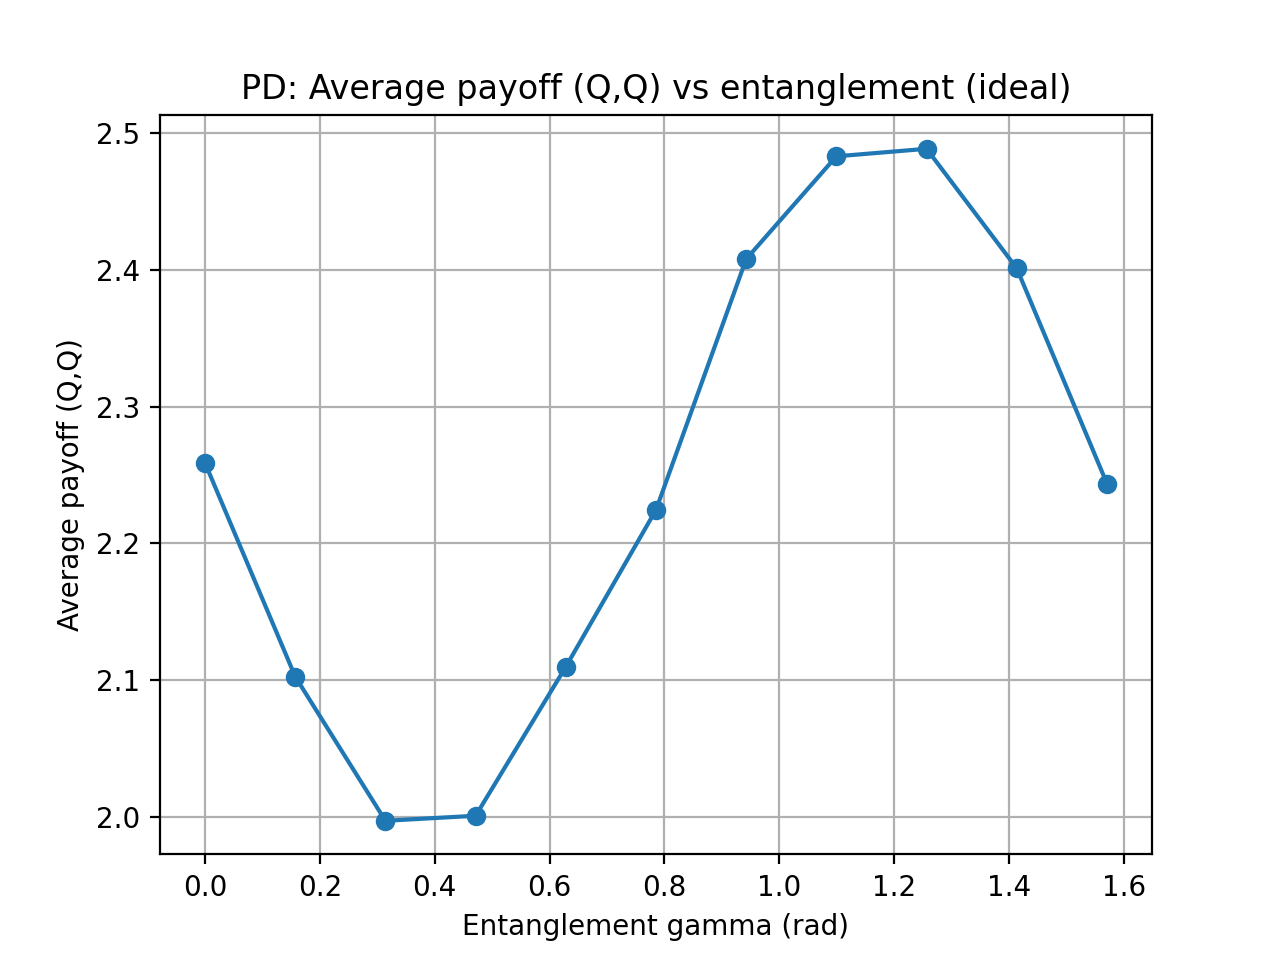

In [9]:
from IPython.display import Image
Image('pd_payoff_vs_gamma.png')

In [4]:
!pip install qiskit-aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 118.0 MB/s eta 0:00:00


In [13]:
!pip install qiskit
!pip install qiskit[visualization]